# Fantasy football wide-receivers points prediction model using neural network

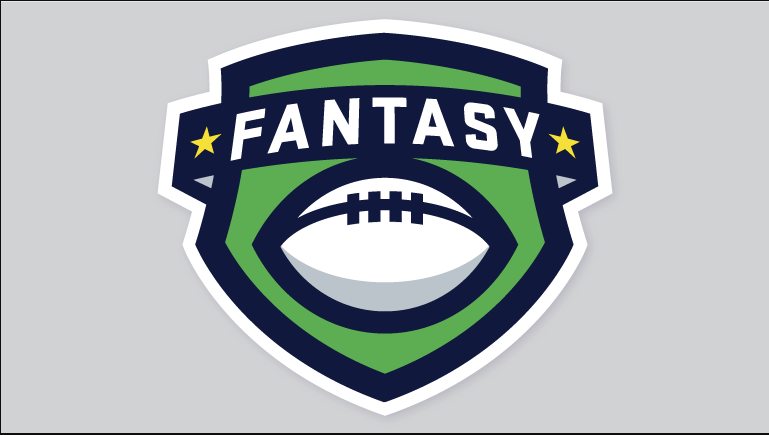


#### Goal of the project : Create a model that will predict the number of points NFL wide receiver should score in the upcoming 2022-2023 season.

#### How : Make use of the massive amount of readily available data on players/fantasy scoring within a neural network.

#### Framework :
    - Standard fantasy football points scoring system
    - Isolate wide-receiver scoring, but the model could very easily be re-used for other positions (RB, QB, TE)
    - Data is fetched from nfl_data_py API
    - Historical range of data used will be 20 years (2000-2020)
    - Use 2021 as the testing data to generate the 2022 predictions
    - Compare the end results to other fantasy football references (ESPN, FantasyPros)
##### Note that I will also be comparing the performance of my neural network against other classical regression models (Linear regression and decision tree)

#### Presentation structure :
    - Introduction to fantasy football (quick :D)
    - Pre-modeling : Fetching data from the API and cleaning
    - Understanding our data
    - The neural network
    - Prediction results
    - Neural network VS classical regression, which performs best?
    - Conclusion

# A quick introduction to fantasy football


Fantasy football is extremely popular amongst nfl (amercian football) fans. Although many only play it for fun, it actually generates billions of dollars every season. https://www.statista.com/statistics/1175890/fantasy-sports-service-industry-market-size-us/#:~:text=The%20market%20size%20of%20the,increase%20over%20the%20previous%20year.

The goal of fantasy football is to build the best team possible from the pool of available players on a given season. Every week, you are playing against other managers and your team has to produce more points than the other to get the win. Points are generated based on the performance of players on that specific week. There are multiple categories of players you need to choose from (RB, WR, QB, TE, K, D). I will be focusing on WR in this project.

Using readily available data, I want to create a model that will be able to predict how many fantasy points the best NFL wide receivers will be scoring next season. This model will then help me make my choices to build my 2022-2023 roster. 

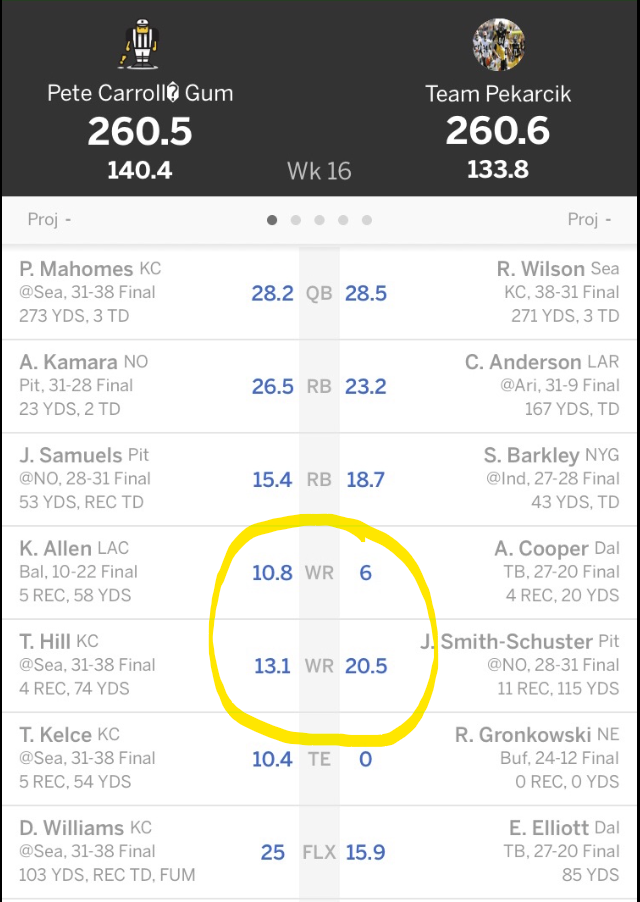

The below image shows the top 2021 WR performers. 

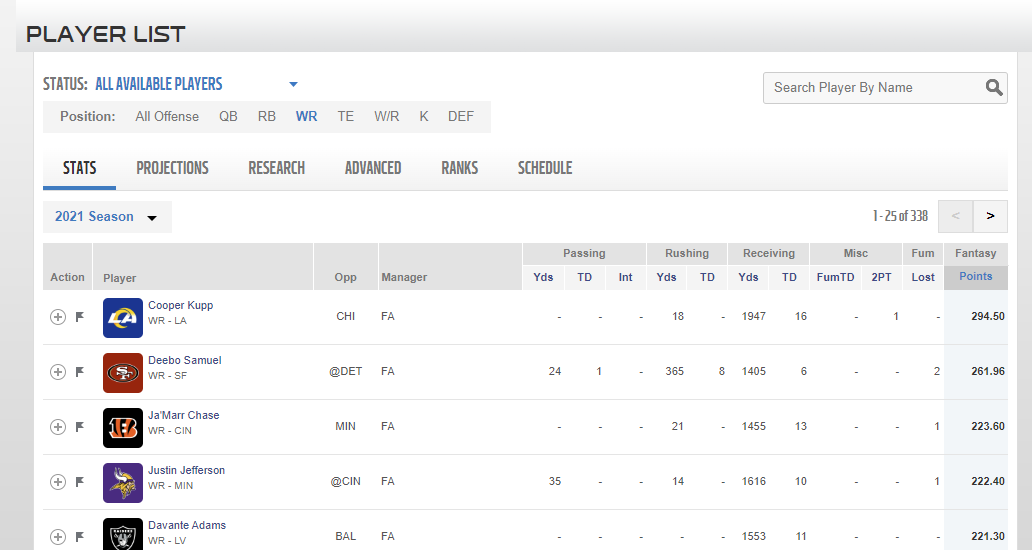

The scoring system is very simple and takes into accounts only a few data points. The way to predict player performance however, is much more complex. There are hundreds of features to choose from when getting into the analysis. Below is a list of them which I will experience with in my neural network.

- Number of targets per game
- Number of catches per game
- Average depth of targets
- Average yards after catch
- Numbers of games played
- Total number of yards/game
- Player age
- Carries
- Touchdown passes caught
- Fumbles

I've reached out to the NFL directly to try and get access to their developer API to get the data but they charge a large annual fee.

https://developer.nfl.com/

I was thinking of scrapping the data directly from the web (plenty of available resources) but luckily there was an existing free API that got me what I needed.

https://pypi.org/project/nfl-data-py/

In [2]:
from datetime import datetime, date
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import  train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Pre-modeling : Getting the data and cleaning

In [3]:
# Loading historical player stats and fantasy points per year

sea_l = [year for year in range(2000,2022)]
drop_l = ['season_type', 'interceptions', 'sacks', 'sack_yards','sack_fumbles', 'sack_fumbles_lost',
         'passing_first_downs', 'passing_epa', 'dakota', 'special_teams_tds', 'fantasy_points_ppr']

df = nfl.import_seasonal_data(sea_l)
df_stats = df[df['season_type'] == 'REG']
df_stats = df_stats.drop(columns=drop_l)
df_stats.head(5)

player_id  season  completions  attempts  passing_yards  passing_tds  \
0  00-0000003    2000            0         0            0.0            0   
1  00-0000007    2000            0         0            0.0            0   
2  00-0000007    2001            0         0            0.0            0   
3  00-0000007    2003            0         0            0.0            0   
4  00-0000007    2004            0         0            0.0            0   

   passing_air_yards  passing_yards_after_catch  passing_2pt_conversions  \
0                0.0                        0.0                        0   
1                0.0                        0.0                        0   
2                0.0                        0.0                        0   
3                0.0                        0.0                        0   
4                0.0                        0.0                        0   

   carries  ...  yac_sh  wopr_y     ry_sh  rtd_sh    rfd_sh  rtdfd_sh  \
0        1  ...     NaN     NaN  0.000000     0.0  0.000000  0.000000   
1       16  ...     NaN     NaN  0.034230     0.0  0.043478  0.041667   
2       11  ...     NaN     NaN  0.064838     0.0  0.095238  0.083333   
3       18  ...     NaN     NaN  0.024091     0.0  0.027273  0.025424   
4       13  ...     NaN     NaN  0.007149     0.0  0.000000  0.000000   

        dom     w8dom    yptmpa    ppr_sh  
0  0.000000  0.000000  0.000000 -0.002418  
1  0.017115  0.027384  0.197183  0.053758  
2  0.032419  0.051870  0.412698  0.054108  
3  0.012046  0.019273  0.139241  0.021780  
4  0.003574  0.005719  0.051136  0.018839  

[5 rows x 47 columns]

In [147]:
# Loading NFL historical rosters to be able to filter on WR and get players AGE which will be an important feature
# Some data cleaning needed to be done here as well. Notably missing DOB which caused issues on later transforms

df1 = nfl.import_rosters(sea_l)

df_players = pd.DataFrame()
df_players['player_id'] = df1['player_id']
df_players['birth_date'] = df1['birth_date']
df_players['position'] = df1['position']
df_players['name'] = df1['first_name'] + ' ' + df1['last_name']

df_players.drop_duplicates(subset ="player_id",keep = 'first', inplace = True)

# Some players DOB was missing everywhere "had to look it up on google"
df_players.loc[df_players.name == 'Brandon Marshall', 'birth_date'] = '1984-03-23'
df_players.loc[df_players.name == 'Brandon LaFell', 'birth_date'] = '1986-11-04'
df_players.loc[df_players.name == 'Eric Decker', 'birth_date'] = '1987-03-15'
df_players.loc[df_players.player_id == '00-0027793', 'birth_date'] = '1988-07-10'
df_players.loc[df_players.player_id == '00-0036900', 'birth_date'] = '2000-03-01'
df_players.loc[df_players.name == 'Dez Bryant', 'birth_date'] = '1988-11-04'
df_players.loc[df_players.name == 'Kelvin Benjamin', 'birth_date'] = '1991-02-05'
df_players.loc[df_players.name == 'Justin Jefferson', 'birth_date'] = '1999-01-16'
df_players.loc[df_players.name == 'Michael Crabtree', 'birth_date'] = '1987-09-14'
df_players.loc[df_players.name == 'Jaylen Waddle', 'birth_date'] = '1998-11-25'
df_players.loc[df_players.name == 'Elijah Moore', 'birth_date'] = '2000-03-27'
df_players.loc[df_players.name == 'Rashod Bateman', 'birth_date'] = '1999-11-29'
df_players.loc[df_players.name == 'Amon-Ra St. Brown', 'birth_date'] = '1999-10-24'
df_players.loc[df_players.name == 'DeVonta Smith', 'birth_date'] = '1998-11-14'
df_players.loc[df_players.name == 'Kadarius Toney', 'birth_date'] = '1999-01-27'

placeh = pd.to_datetime('1900-01-01')
df_players['birth_date'] = df_players['birth_date'].fillna(placeh)

df_players.tail(5)

Empty DataFrame
Columns: [player_id, birth_date, position, name]
Index: []

In [149]:
# Merge the players and stats dataframe to get ALL the data required in one place. Filter on 'WR' only

df_full = pd.merge(df_stats,df_players,on = 'player_id',how='left')
df_wr_full = df_full[df_full.position == 'WR']
df_wr_full[df_wr_full['name'] == 'Antonio Brown']

player_id  season  completions  attempts  passing_yards  passing_tds  \
3834  00-0021425    2003            0         0            0.0            0   
3835  00-0021425    2005            0         0            0.0            0   
7980  00-0027793    2010            0         0            0.0            0   
7981  00-0027793    2011            0         0            0.0            0   
7982  00-0027793    2012            0         2            0.0            0   
7983  00-0027793    2013            1         1           15.0            0   
7984  00-0027793    2014            2         2           20.0            1   
7985  00-0027793    2015            0         0            0.0            0   
7986  00-0027793    2016            0         0            0.0            0   
7987  00-0027793    2017            0         0            0.0            0   
7988  00-0027793    2018            0         1            0.0            0   
7989  00-0027793    2019            0         0            0.0            0   
7990  00-0027793    2020            0         0            0.0            0   
7991  00-0027793    2021            0         0            0.0            0   

      passing_air_yards  passing_yards_after_catch  passing_2pt_conversions  \
3834                0.0                        0.0                        0   
3835                0.0                        0.0                        0   
7980                0.0                        0.0                        0   
7981                0.0                        0.0                        0   
7982               41.0                        0.0                        0   
7983               11.0                        4.0                        0   
7984                9.0                       11.0                        0   
7985                0.0                        0.0                        0   
7986                0.0                        0.0                        0   
7987                0.0                        0.0                        0   
7988               12.0                        0.0                        0   
7989                0.0                        0.0                        0   
7990                0.0                        0.0                        0   
7991                0.0                        0.0                        0   

      carries  ...    rtd_sh    rfd_sh  rtdfd_sh       dom     w8dom  \
3834        1  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
3835        2  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
7980        0  ...  0.000000  0.114943  0.104167  0.044439  0.071102   
7981        7  ...  0.095238  0.257919  0.243802  0.175475  0.223617   
7982        7  ...  0.192308  0.247126  0.240000  0.209981  0.220585   
7983        7  ...  0.285714  0.338164  0.331915  0.316917  0.335638   
7984        4  ...  0.393939  0.349794  0.355072  0.366872  0.350631   
7985        3  ...  0.384615  0.405797  0.403433  0.382478  0.381195   
7986        3  ...  0.400000  0.328205  0.337778  0.356585  0.330537   
7987        0  ...  0.346154  0.362245  0.360360  0.361452  0.370632   
7988        0  ...  0.441176  0.264706  0.286765  0.353287  0.300554   
7989        1  ...  0.500000  0.230769  0.266667  0.356061  0.269697   
7990        2  ...  0.181818  0.216000  0.210884  0.184260  0.185726   
7991        1  ...  0.200000  0.233871  0.229167  0.217711  0.228337   

        yptmpa    ppr_sh  birth_date  position           name  
3834  0.000000  0.018731  1900-01-01        WR  Antonio Brown  
3835  0.000000  0.032196  1900-01-01        WR  Antonio Brown  
7980  0.684426  0.060653  1988-07-10        WR  Antonio Brown  
7981  2.055659  0.146738  1988-07-10        WR  Antonio Brown  
7982  1.678038  0.147209  1988-07-10        WR  Antonio Brown  
7983  2.558020  0.223074  1988-07-10        WR  Antonio Brown  
7984  2.774510  0.233661  1988-07-10        WR  Antonio Brown  
7985  3.108475  0.246840  1988-07-10      

In [150]:
# Still have some missing DOB, needed to get the info from another source

df_dob = pd.read_csv('C:/Users/phili/Onedrive/Desktop/players_dat.txt',header=1)
df_dob1 = df_dob[(df_dob['Rk'] != 'Rk') & (df_dob['Rk'].notnull())]
s1 = []

# Clean players name from the file
for i in df_dob1['Player']:
    s1.append(i.split('\\')[0].split('*')[0])
    
df_dob1['name'] = s1

df_dob2 = pd.DataFrame()
df_dob2['name'] = df_dob1['name']
df_dob2['season'] = df_dob1['Year']
df_dob2['age'] = df_dob1['Age']

df_dob2 = df_dob2.reset_index(drop=True)
df_dob2['season'] = df_dob2['season'].astype(str).astype(int)

df_dob2

name  season age
0           Jerry Rice    1987  25
1         Wes Chandler    1982  26
2           Jerry Rice    1995  33
3           Randy Moss    2007  30
4        Anthony Allen    1987  28
...                ...     ...  ..
6456       Devon Wylie    2014  26
6457       Milton Wynn    2002  24
6458       Craig Yeast    2001  25
6459        Mike Young    1994  32
6460  Kevin Youngblood    2006  26

[6461 rows x 3 columns]

In [151]:
# Data cleaning continues
# One source had the player age, the other the DOB. Create a function to extract the player age from current SEASON and
# DOB.

def age(old,new):
    old = old
    new = new
    return -(new.year - old.year - ((new.month, new.day) < (old.month,old.day)))

df_conv = pd.merge(df_wr_full,df_dob2,on=['name','season'],how='left')
df_conv = df_conv.drop_duplicates(subset=['player_id','season'])
df_conv['season'] = pd.to_datetime(df_conv['season'], format='%Y')

true_age = []   

for row in df_conv.iterrows():
    true_age.append(age(row[1][1],row[1][47]))

df_conv['age2'] = true_age
df_wr = df_conv

final_l = []

for row in df_wr.iterrows():
    if row[1][51] > 80:
        final_l.append(row[1][50])
    else:
        final_l.append(row[1][51])
        
# More data cleaning
        
df_wr['fin'] = final_l
df_wr['age'] = df_wr['fin']
df_wr = df_wr.drop(columns=['age2','fin','birth_date'])
df_wr = df_wr[df_wr['age'].notna()]
df_wr = df_wr.reset_index(drop=True)
df_wr['season'] = df_wr['season'].dt.year.astype(str).astype(int)
df_wr['age'] = df_wr['age'].astype(str).astype(int)
df_wr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_wr = df_wr.fillna(0)

# Historical data distribution

### Distribution of individual players points per seasons

Text(0, 0.5, 'Fantasy Points')

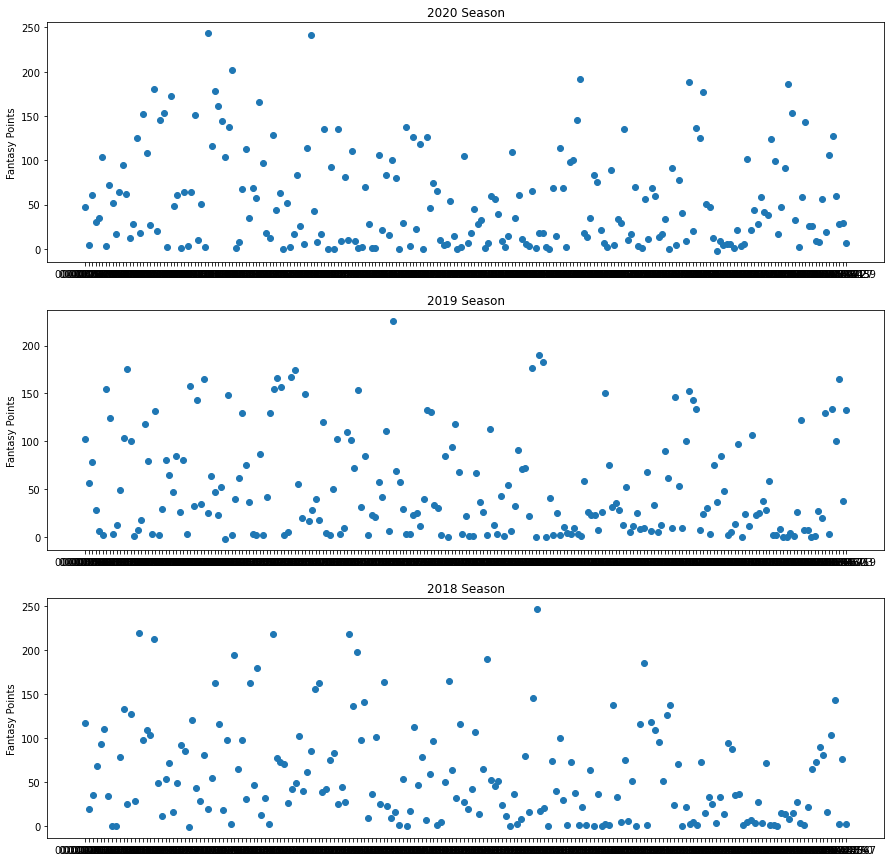

In [152]:
x4 = df_wr[df_wr['season'] == 2020]['player_id']
y4 = df_wr[df_wr['season'] == 2020]['fantasy_points']

x5 = df_wr[df_wr['season'] == 2019]['player_id']
y5 = df_wr[df_wr['season'] == 2019]['fantasy_points']

x6 = df_wr[df_wr['season'] == 2018]['player_id']
y6 = df_wr[df_wr['season'] == 2018]['fantasy_points']

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].scatter(x4,y4)
ax[0].set_ylabel('Fantasy Points')
ax[0].title.set_text('2020 Season')
ax[1].scatter(x5,y5)
ax[1].set_ylabel('Fantasy Points')
ax[1].title.set_text('2019 Season')
ax[2].scatter(x6,y6)
ax[2].title.set_text('2018 Season')
ax[2].set_ylabel('Fantasy Points')

### Number of players per points brackets in a given year

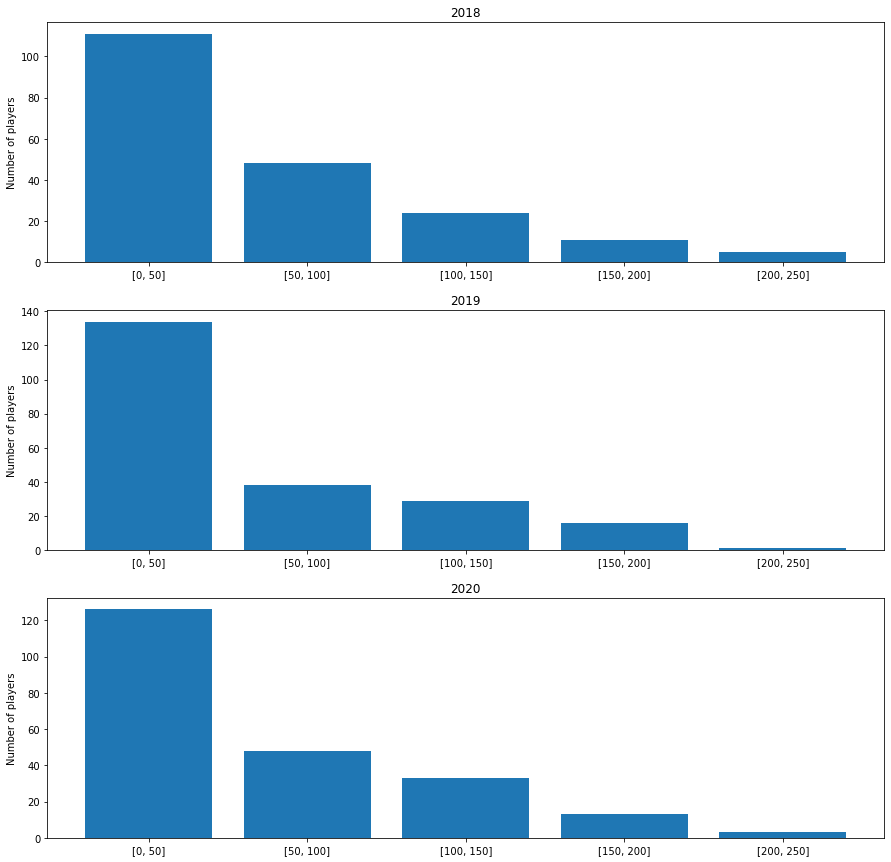

In [153]:
y2018 = {}
y2019 = {}
y2020 = {}

for i in [2018,2019,2020]:
    for j in [[0,50],[50,100],[100,150],[150,200],[200,250]]:
        if i == 2018:
            y2018[str(j)] = len(df_wr[(df_wr['season'] == i) & (df_wr['fantasy_points'] >= j[0]) &
                            (df_wr['fantasy_points'] < j[1])]['fantasy_points'])
        if i == 2019:
            y2019[str(j)] = len(df_wr[(df_wr['season'] == i) & (df_wr['fantasy_points'] >= j[0]) &
                            (df_wr['fantasy_points'] < j[1])]['fantasy_points'])

        if i == 2020:
            y2020[str(j)] = len(df_wr[(df_wr['season'] == i) & (df_wr['fantasy_points'] >= j[0]) &
                            (df_wr['fantasy_points'] < j[1])]['fantasy_points'])
            
x2018 = pd.DataFrame.from_dict(y2018, orient='index')
x2019 = pd.DataFrame.from_dict(y2019, orient='index')
x2020 = pd.DataFrame.from_dict(y2020, orient='index')

x7 = np.array(x2018.index)
y7 = x2018[0]

x8 = np.array(x2019.index)
y8 = x2019[0]

x9 = np.array(x2020.index)
y9 = x2020[0]

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].bar(x7,y7)
ax[0].set_ylabel('Number of players')
ax[0].title.set_text('2018')
ax[1].bar(x8,y8)
ax[1].set_ylabel('Number of players')
ax[1].title.set_text('2019')
ax[2].bar(x9,y9)
ax[2].set_ylabel('Number of players')
ax[2].title.set_text('2020')


### Display of fantasy points (dependent var) per year and how it swings even for good players

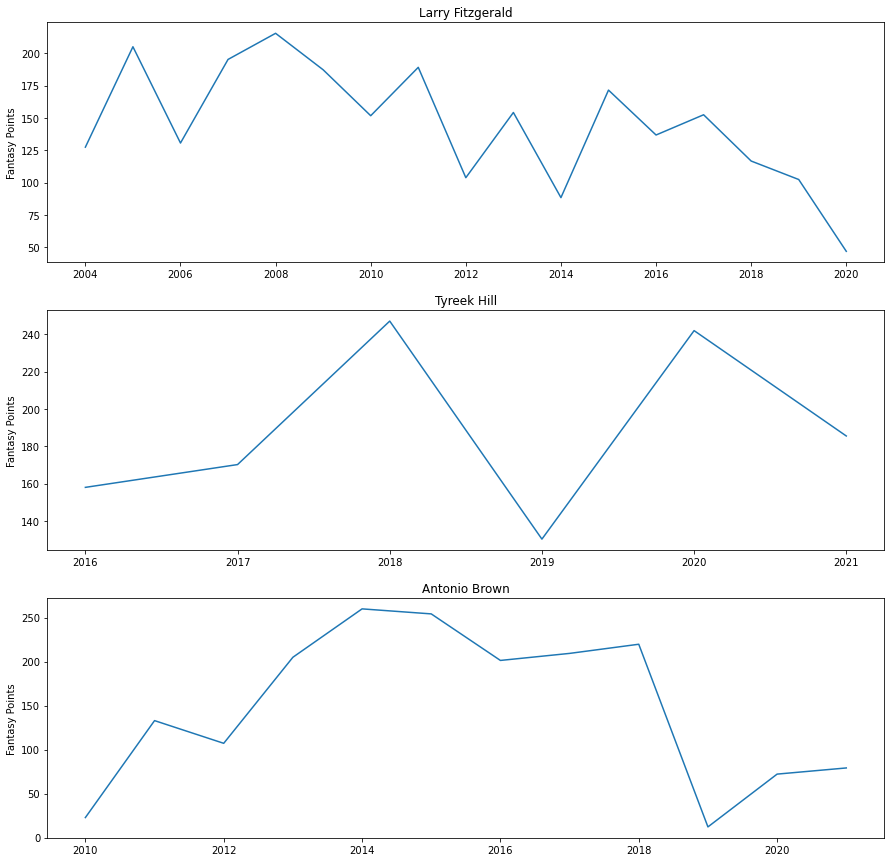

In [154]:
x1 = df_wr[df_wr['name'] == 'Larry Fitzgerald']['season']
y1 = df_wr[df_wr['name'] == 'Larry Fitzgerald']['fantasy_points']

x2 = df_wr[df_wr['name'] == 'Tyreek Hill']['season']
y2 = df_wr[df_wr['name'] == 'Tyreek Hill']['fantasy_points']

x3 = df_wr[df_wr['player_id'] == '00-0027793']['season'] # Antonio Brown
y3 = df_wr[df_wr['player_id'] == '00-0027793']['fantasy_points']

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(x1,y1)
ax[0].set_ylabel('Fantasy Points')
ax[0].title.set_text('Larry Fitzgerald')
ax[1].plot(x2,y2)
ax[1].set_ylabel('Fantasy Points')
ax[1].title.set_text('Tyreek Hill')
ax[2].plot(x3,y3)
ax[2].title.set_text('Antonio Brown')
ax[2].set_ylabel('Fantasy Points')

plt.show()

In [155]:
# Just saving my raw data in case something goes wrong with the API while i'm experimenting with my project

df_wr.to_csv("C:/Users/phili/OneDrive/Desktop/df_wr.txt")
df_wr_full.to_csv("C:/Users/phili/OneDrive/Desktop/df_wr_full.txt")

# The neural network

### Complete list of features to predict player performance

In [156]:
for i in df_wr.columns:
    print(i)

player_id
season
completions
attempts
passing_yards
passing_tds
passing_air_yards
passing_yards_after_catch
passing_2pt_conversions
carries
rushing_yards
rushing_tds
rushing_fumbles
rushing_fumbles_lost
rushing_first_downs
rushing_epa
rushing_2pt_conversions
receptions
targets
receiving_yards
receiving_tds
receiving_fumbles
receiving_fumbles_lost
receiving_air_yards
receiving_yards_after_catch
receiving_first_downs
receiving_epa
receiving_2pt_conversions
fantasy_points
pacr
racr
target_share
air_yards_share
wopr_x
games
tgt_sh
ay_sh
yac_sh
wopr_y
ry_sh
rtd_sh
rfd_sh
rtdfd_sh
dom
w8dom
yptmpa
ppr_sh
position
name
age


In [157]:
# Excluding 2021 data points from X, these are our validation/prediction data points.

X = df_wr[df_wr['season'] != 2021]
y = X['fantasy_points']
X = X.drop(columns=['player_id','position','name','fantasy_points'])

# Tried removing more features when running the neural net to see if it would affect it's performance/accuracy

# X = X.drop(columns=['player_id','position','name','fantasy_points',
#                    'completions', 'attempts', 'passing_yards',
#                    'passing_tds', 'passing_air_yards', 'passing_yards_after_catch',
#                    'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds',
#                    'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs',
#                    'rushing_epa', 'rushing_2pt_conversions'])

# Using sklearn StandardScaler function to standardise our data. We have a large amount of features, each of which 
# are on different scales. Results would not make any sense if we didn't standaradize the input.

X = StandardScaler().fit_transform(X)

# I played with test size during the experimental phases, 0.25 seemed like a good ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Training data length: {len(X_train)}")

print(f"Testing data shape: {X_test.shape}")
print(f"Testing data length: {len(X_test)}")

Training data shape: (2307, 46)
Training data length: 2307
Testing data shape: (770, 46)
Testing data length: 770


### Model details

The next few cells will show the configuration of the neural network as well as the training and the results I've achieved. A lot of iterations were tried to find the best possible configuration for the model. Some parameters I've played with include :
- Kernel initializer
- Activation function for input, dense and output layers
- Batch normalization
- Loss functions
- Optimizers
- Dropouts
- Number of features used
- Number of dense layers
- Number of units (neurons) per layers

I've even tried to convert my input into a 46x46x1 matrix to use Conv2D layers, it didnt' yield better accuracy in the end.

In [121]:
# The model
model = tf.keras.Sequential()
model.add(Dense(28, input_shape=(46,), kernel_initializer='normal',activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae","mse"])

In [122]:
from keras import backend as K

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 28)                1316      
                                                                 
 dense_17 (Dense)            (None, 64)                1856      
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                

### Running the model

In [123]:
# es = EarlyStopping(monitor='val_loss', patience=200)
K.set_value(model.optimizer.learning_rate, 0.001) #0.001 = DEFAULT
epochs = 1000
# history = model.fit(X_train, y_train, batch_size=10, validation_split=0.1, epochs=epochs, callbacks=[es])
history = model.fit(X_train, y_train, batch_size=10, validation_split=0.1, epochs=epochs)

Epoch 1/1000
208/208 [==============================] - 1s 1ms/step - loss: 1882.9550 - mae: 27.0237 - mse: 1882.9552 - val_loss: 90.4096 - val_mae: 7.0970 - val_mse: 90.4096
Epoch 2/1000
208/208 [==============================] - 0s 761us/step - loss: 321.4268 - mae: 11.6541 - mse: 321.4268 - val_loss: 56.5118 - val_mae: 5.5018 - val_mse: 56.5118
Epoch 3/1000
208/208 [==============================] - 0s 747us/step - loss: 353.3177 - mae: 11.9097 - mse: 353.3177 - val_loss: 87.9601 - val_mae: 6.8286 - val_mse: 87.9601
Epoch 4/1000
208/208 [==============================] - 0s 766us/step - loss: 304.4955 - mae: 10.9257 - mse: 304.4955 - val_loss: 53.3751 - val_mae: 5.1497 - val_mse: 53.3751
Epoch 5/1000
208/208 [==============================] - 0s 807us/step - loss: 280.4893 - mae: 10.4812 - mse: 280.4893 - val_loss: 99.2218 - val_mae: 7.3852 - val_mse: 99.2218
Epoch 6/1000
208/208 [==============================] - 0s 747us/step - loss: 285.2809 - mae: 10.7564 - mse: 285.2809 - val_l

Epoch 48/1000
208/208 [==============================] - 0s 747us/step - loss: 248.2210 - mae: 9.6924 - mse: 248.2210 - val_loss: 62.2828 - val_mae: 5.8299 - val_mse: 62.2828
Epoch 49/1000
208/208 [==============================] - 0s 752us/step - loss: 246.2897 - mae: 9.3995 - mse: 246.2897 - val_loss: 30.6022 - val_mae: 3.7366 - val_mse: 30.6022
Epoch 50/1000
208/208 [==============================] - 0s 744us/step - loss: 226.7656 - mae: 9.3912 - mse: 226.7656 - val_loss: 23.5335 - val_mae: 3.4710 - val_mse: 23.5335
Epoch 51/1000
208/208 [==============================] - 0s 752us/step - loss: 235.7839 - mae: 9.3910 - mse: 235.7839 - val_loss: 12.5570 - val_mae: 2.5038 - val_mse: 12.5570
Epoch 52/1000
208/208 [==============================] - 0s 745us/step - loss: 244.5331 - mae: 9.3105 - mse: 244.5331 - val_loss: 55.0314 - val_mae: 4.9033 - val_mse: 55.0314
Epoch 53/1000
208/208 [==============================] - 0s 742us/step - loss: 242.3403 - mae: 9.3712 - mse: 242.3403 - val_l

Epoch 95/1000
208/208 [==============================] - 0s 752us/step - loss: 203.7339 - mae: 8.6303 - mse: 203.7339 - val_loss: 14.3150 - val_mae: 2.4584 - val_mse: 14.3150
Epoch 96/1000
208/208 [==============================] - 0s 751us/step - loss: 203.9539 - mae: 8.5569 - mse: 203.9539 - val_loss: 7.1734 - val_mae: 1.8401 - val_mse: 7.1734
Epoch 97/1000
208/208 [==============================] - 0s 781us/step - loss: 232.9817 - mae: 9.1258 - mse: 232.9817 - val_loss: 32.4918 - val_mae: 3.8224 - val_mse: 32.4918
Epoch 98/1000
208/208 [==============================] - 0s 771us/step - loss: 210.8622 - mae: 8.6828 - mse: 210.8622 - val_loss: 13.6618 - val_mae: 2.4923 - val_mse: 13.6618
Epoch 99/1000
208/208 [==============================] - 0s 747us/step - loss: 248.3331 - mae: 9.3759 - mse: 248.3331 - val_loss: 43.0823 - val_mae: 4.3842 - val_mse: 43.0823
Epoch 100/1000
208/208 [==============================] - 0s 752us/step - loss: 227.6100 - mae: 8.9892 - mse: 227.6100 - val_lo

208/208 [==============================] - 0s 747us/step - loss: 197.4141 - mae: 8.3774 - mse: 197.4141 - val_loss: 10.1847 - val_mae: 2.0103 - val_mse: 10.1847
Epoch 142/1000
208/208 [==============================] - 0s 761us/step - loss: 231.9653 - mae: 8.8432 - mse: 231.9653 - val_loss: 13.7100 - val_mae: 2.5024 - val_mse: 13.7100
Epoch 143/1000
208/208 [==============================] - 0s 862us/step - loss: 204.7195 - mae: 8.2267 - mse: 204.7195 - val_loss: 12.9721 - val_mae: 2.5132 - val_mse: 12.9721
Epoch 144/1000
208/208 [==============================] - 0s 752us/step - loss: 198.5347 - mae: 8.4716 - mse: 198.5347 - val_loss: 7.4580 - val_mae: 1.7535 - val_mse: 7.4580
Epoch 145/1000
208/208 [==============================] - 0s 756us/step - loss: 211.6363 - mae: 8.4635 - mse: 211.6363 - val_loss: 20.0597 - val_mae: 3.0521 - val_mse: 20.0597
Epoch 146/1000
208/208 [==============================] - 0s 761us/step - loss: 218.2076 - mae: 8.7494 - mse: 218.2076 - val_loss: 45.001

Epoch 188/1000
208/208 [==============================] - 0s 785us/step - loss: 215.6932 - mae: 8.4997 - mse: 215.6932 - val_loss: 8.3180 - val_mae: 1.9741 - val_mse: 8.3180
Epoch 189/1000
208/208 [==============================] - 0s 848us/step - loss: 205.1221 - mae: 8.2827 - mse: 205.1221 - val_loss: 6.7608 - val_mae: 1.7306 - val_mse: 6.7608
Epoch 190/1000
208/208 [==============================] - 0s 800us/step - loss: 183.7352 - mae: 8.0612 - mse: 183.7352 - val_loss: 10.7847 - val_mae: 1.9039 - val_mse: 10.7847
Epoch 191/1000
208/208 [==============================] - 0s 752us/step - loss: 168.9914 - mae: 7.9818 - mse: 168.9914 - val_loss: 14.3284 - val_mae: 2.4832 - val_mse: 14.3284
Epoch 192/1000
208/208 [==============================] - 0s 747us/step - loss: 216.7582 - mae: 8.8216 - mse: 216.7582 - val_loss: 27.5683 - val_mae: 3.4514 - val_mse: 27.5683
Epoch 193/1000
208/208 [==============================] - 0s 736us/step - loss: 189.7200 - mae: 8.1481 - mse: 189.7200 - val

Epoch 235/1000
208/208 [==============================] - 0s 756us/step - loss: 214.8133 - mae: 8.4584 - mse: 214.8133 - val_loss: 17.2671 - val_mae: 2.8345 - val_mse: 17.2671
Epoch 236/1000
208/208 [==============================] - 0s 752us/step - loss: 201.6863 - mae: 8.3428 - mse: 201.6863 - val_loss: 16.1030 - val_mae: 2.3854 - val_mse: 16.1030
Epoch 237/1000
208/208 [==============================] - 0s 752us/step - loss: 186.3689 - mae: 8.0302 - mse: 186.3689 - val_loss: 10.9102 - val_mae: 2.2112 - val_mse: 10.9102
Epoch 238/1000
208/208 [==============================] - 0s 752us/step - loss: 179.6889 - mae: 7.9025 - mse: 179.6889 - val_loss: 69.5977 - val_mae: 5.6237 - val_mse: 69.5977
Epoch 239/1000
208/208 [==============================] - 0s 771us/step - loss: 177.7097 - mae: 7.9998 - mse: 177.7097 - val_loss: 7.8596 - val_mae: 1.9514 - val_mse: 7.8596
Epoch 240/1000
208/208 [==============================] - 0s 790us/step - loss: 185.1493 - mae: 7.8986 - mse: 185.1493 - v

208/208 [==============================] - 0s 776us/step - loss: 194.9866 - mae: 8.0085 - mse: 194.9866 - val_loss: 20.1002 - val_mae: 3.3423 - val_mse: 20.1002
Epoch 282/1000
208/208 [==============================] - 0s 752us/step - loss: 168.8088 - mae: 7.8171 - mse: 168.8088 - val_loss: 27.7990 - val_mae: 3.5180 - val_mse: 27.7990
Epoch 283/1000
208/208 [==============================] - 0s 742us/step - loss: 202.1408 - mae: 8.2370 - mse: 202.1408 - val_loss: 12.5424 - val_mae: 2.2958 - val_mse: 12.5424
Epoch 284/1000
208/208 [==============================] - 0s 746us/step - loss: 196.0907 - mae: 8.2255 - mse: 196.0907 - val_loss: 8.2216 - val_mae: 1.8108 - val_mse: 8.2216
Epoch 285/1000
208/208 [==============================] - 0s 742us/step - loss: 168.7314 - mae: 7.9159 - mse: 168.7314 - val_loss: 28.5794 - val_mae: 3.7326 - val_mse: 28.5794
Epoch 286/1000
208/208 [==============================] - 0s 732us/step - loss: 160.0158 - mae: 7.5923 - mse: 160.0158 - val_loss: 26.671

Epoch 328/1000
208/208 [==============================] - 0s 757us/step - loss: 175.5011 - mae: 7.5840 - mse: 175.5011 - val_loss: 9.0309 - val_mae: 2.0573 - val_mse: 9.0309
Epoch 329/1000
208/208 [==============================] - 0s 723us/step - loss: 165.2875 - mae: 7.7058 - mse: 165.2875 - val_loss: 30.7629 - val_mae: 3.6639 - val_mse: 30.7629
Epoch 330/1000
208/208 [==============================] - 0s 723us/step - loss: 182.4826 - mae: 7.8001 - mse: 182.4826 - val_loss: 31.1876 - val_mae: 3.6854 - val_mse: 31.1876
Epoch 331/1000
208/208 [==============================] - 0s 755us/step - loss: 167.0462 - mae: 7.5022 - mse: 167.0462 - val_loss: 37.5733 - val_mae: 4.3463 - val_mse: 37.5733
Epoch 332/1000
208/208 [==============================] - 0s 748us/step - loss: 164.4418 - mae: 7.6404 - mse: 164.4418 - val_loss: 7.7538 - val_mae: 1.8972 - val_mse: 7.7538
Epoch 333/1000
208/208 [==============================] - 0s 747us/step - loss: 176.0638 - mae: 7.8161 - mse: 176.0638 - val

Epoch 375/1000
208/208 [==============================] - 0s 737us/step - loss: 181.9746 - mae: 7.9502 - mse: 181.9746 - val_loss: 21.2382 - val_mae: 3.1903 - val_mse: 21.2382
Epoch 376/1000
208/208 [==============================] - 0s 776us/step - loss: 151.1574 - mae: 7.3636 - mse: 151.1574 - val_loss: 17.0539 - val_mae: 2.7569 - val_mse: 17.0539
Epoch 377/1000
208/208 [==============================] - 0s 742us/step - loss: 141.8922 - mae: 7.2949 - mse: 141.8922 - val_loss: 57.0870 - val_mae: 5.0070 - val_mse: 57.0870
Epoch 378/1000
208/208 [==============================] - 0s 732us/step - loss: 164.3035 - mae: 7.6279 - mse: 164.3035 - val_loss: 28.9051 - val_mae: 3.6343 - val_mse: 28.9051
Epoch 379/1000
208/208 [==============================] - 0s 732us/step - loss: 148.3401 - mae: 7.1867 - mse: 148.3401 - val_loss: 15.5150 - val_mae: 2.6496 - val_mse: 15.5150
Epoch 380/1000
208/208 [==============================] - 0s 770us/step - loss: 156.9272 - mae: 7.5576 - mse: 156.9272 -

Epoch 422/1000
208/208 [==============================] - 0s 809us/step - loss: 179.3565 - mae: 7.8641 - mse: 179.3565 - val_loss: 31.3435 - val_mae: 3.8755 - val_mse: 31.3435
Epoch 423/1000
208/208 [==============================] - 0s 1ms/step - loss: 150.8520 - mae: 7.4026 - mse: 150.8520 - val_loss: 8.5327 - val_mae: 2.0136 - val_mse: 8.5327
Epoch 424/1000
208/208 [==============================] - 0s 1ms/step - loss: 153.9677 - mae: 7.5558 - mse: 153.9677 - val_loss: 15.0750 - val_mae: 2.7125 - val_mse: 15.0750
Epoch 425/1000
208/208 [==============================] - 0s 1ms/step - loss: 152.9925 - mae: 7.4725 - mse: 152.9925 - val_loss: 11.0969 - val_mae: 2.5416 - val_mse: 11.0969
Epoch 426/1000
208/208 [==============================] - 0s 997us/step - loss: 150.0221 - mae: 7.3305 - mse: 150.0221 - val_loss: 8.3876 - val_mae: 1.9057 - val_mse: 8.3876
Epoch 427/1000
208/208 [==============================] - 0s 992us/step - loss: 173.9130 - mae: 7.6228 - mse: 173.9130 - val_loss:

Epoch 469/1000
208/208 [==============================] - 0s 752us/step - loss: 145.9564 - mae: 7.3870 - mse: 145.9564 - val_loss: 8.8635 - val_mae: 1.8039 - val_mse: 8.8635
Epoch 470/1000
208/208 [==============================] - 0s 737us/step - loss: 154.1224 - mae: 7.4985 - mse: 154.1224 - val_loss: 15.0116 - val_mae: 2.6961 - val_mse: 15.0116
Epoch 471/1000
208/208 [==============================] - 0s 734us/step - loss: 141.6188 - mae: 7.0936 - mse: 141.6188 - val_loss: 23.3915 - val_mae: 3.2541 - val_mse: 23.3915
Epoch 472/1000
208/208 [==============================] - 0s 732us/step - loss: 134.7389 - mae: 7.2262 - mse: 134.7389 - val_loss: 8.4918 - val_mae: 1.9078 - val_mse: 8.4918
Epoch 473/1000
208/208 [==============================] - 0s 758us/step - loss: 149.4814 - mae: 7.2330 - mse: 149.4814 - val_loss: 27.5932 - val_mae: 3.4122 - val_mse: 27.5932
Epoch 474/1000
208/208 [==============================] - 0s 771us/step - loss: 149.8208 - mae: 7.3833 - mse: 149.8208 - val

Epoch 516/1000
208/208 [==============================] - 0s 732us/step - loss: 140.7204 - mae: 7.0645 - mse: 140.7205 - val_loss: 31.8186 - val_mae: 3.5901 - val_mse: 31.8186
Epoch 517/1000
208/208 [==============================] - 0s 737us/step - loss: 151.0659 - mae: 7.3709 - mse: 151.0659 - val_loss: 11.1561 - val_mae: 2.6408 - val_mse: 11.1561
Epoch 518/1000
208/208 [==============================] - 0s 733us/step - loss: 138.6462 - mae: 7.2601 - mse: 138.6462 - val_loss: 20.9731 - val_mae: 3.2223 - val_mse: 20.9731
Epoch 519/1000
208/208 [==============================] - 0s 742us/step - loss: 140.8588 - mae: 7.2148 - mse: 140.8588 - val_loss: 8.6156 - val_mae: 2.1457 - val_mse: 8.6156
Epoch 520/1000
208/208 [==============================] - 0s 737us/step - loss: 133.9932 - mae: 7.1428 - mse: 133.9932 - val_loss: 6.1909 - val_mae: 1.7105 - val_mse: 6.1909
Epoch 521/1000
208/208 [==============================] - 0s 737us/step - loss: 135.3160 - mae: 7.1557 - mse: 135.3160 - val

Epoch 563/1000
208/208 [==============================] - 0s 841us/step - loss: 140.1805 - mae: 7.2665 - mse: 140.1805 - val_loss: 11.8000 - val_mae: 2.2002 - val_mse: 11.8000
Epoch 564/1000
208/208 [==============================] - 0s 809us/step - loss: 131.6791 - mae: 7.1767 - mse: 131.6791 - val_loss: 9.9386 - val_mae: 2.3812 - val_mse: 9.9386
Epoch 565/1000
208/208 [==============================] - 0s 819us/step - loss: 151.4105 - mae: 7.4289 - mse: 151.4105 - val_loss: 37.1342 - val_mae: 3.9293 - val_mse: 37.1342
Epoch 566/1000
208/208 [==============================] - 0s 925us/step - loss: 142.3231 - mae: 7.1553 - mse: 142.3231 - val_loss: 14.5918 - val_mae: 2.6068 - val_mse: 14.5918
Epoch 567/1000
208/208 [==============================] - 0s 795us/step - loss: 138.4423 - mae: 7.1615 - mse: 138.4423 - val_loss: 52.4608 - val_mae: 4.5613 - val_mse: 52.4608
Epoch 568/1000
208/208 [==============================] - 0s 838us/step - loss: 154.1778 - mae: 7.3859 - mse: 154.1778 - v

Epoch 610/1000
208/208 [==============================] - 0s 795us/step - loss: 149.1334 - mae: 7.4186 - mse: 149.1334 - val_loss: 53.7689 - val_mae: 5.1058 - val_mse: 53.7689
Epoch 611/1000
208/208 [==============================] - 0s 750us/step - loss: 139.8995 - mae: 7.3628 - mse: 139.8995 - val_loss: 21.7236 - val_mae: 3.1481 - val_mse: 21.7236
Epoch 612/1000
208/208 [==============================] - 0s 756us/step - loss: 133.9241 - mae: 7.1829 - mse: 133.9241 - val_loss: 10.7960 - val_mae: 2.0792 - val_mse: 10.7960
Epoch 613/1000
208/208 [==============================] - 0s 766us/step - loss: 132.1231 - mae: 7.1362 - mse: 132.1231 - val_loss: 12.2019 - val_mae: 2.7203 - val_mse: 12.2019
Epoch 614/1000
208/208 [==============================] - 0s 742us/step - loss: 123.7899 - mae: 6.9703 - mse: 123.7899 - val_loss: 23.3870 - val_mae: 3.6314 - val_mse: 23.3870
Epoch 615/1000
208/208 [==============================] - 0s 747us/step - loss: 134.5214 - mae: 7.1055 - mse: 134.5214 -

Epoch 657/1000
208/208 [==============================] - 0s 781us/step - loss: 151.2145 - mae: 7.3534 - mse: 151.2145 - val_loss: 13.3874 - val_mae: 2.7064 - val_mse: 13.3874
Epoch 658/1000
208/208 [==============================] - 0s 776us/step - loss: 141.6291 - mae: 7.2886 - mse: 141.6291 - val_loss: 9.7026 - val_mae: 2.1376 - val_mse: 9.7026
Epoch 659/1000
208/208 [==============================] - 0s 771us/step - loss: 134.1099 - mae: 7.2705 - mse: 134.1099 - val_loss: 25.6479 - val_mae: 3.3135 - val_mse: 25.6479
Epoch 660/1000
208/208 [==============================] - 0s 766us/step - loss: 148.0827 - mae: 7.3957 - mse: 148.0827 - val_loss: 28.3751 - val_mae: 3.3390 - val_mse: 28.3751
Epoch 661/1000
208/208 [==============================] - 0s 761us/step - loss: 131.7754 - mae: 7.1198 - mse: 131.7754 - val_loss: 29.8217 - val_mae: 3.4358 - val_mse: 29.8217
Epoch 662/1000
208/208 [==============================] - 0s 756us/step - loss: 132.6718 - mae: 7.1849 - mse: 132.6718 - v

Epoch 704/1000
208/208 [==============================] - 0s 737us/step - loss: 144.9543 - mae: 7.4019 - mse: 144.9543 - val_loss: 40.0477 - val_mae: 3.8181 - val_mse: 40.0477
Epoch 705/1000
208/208 [==============================] - 0s 732us/step - loss: 132.8958 - mae: 7.2964 - mse: 132.8958 - val_loss: 21.1150 - val_mae: 3.1385 - val_mse: 21.1150
Epoch 706/1000
208/208 [==============================] - 0s 737us/step - loss: 129.4803 - mae: 7.1544 - mse: 129.4803 - val_loss: 15.5696 - val_mae: 2.7761 - val_mse: 15.5696
Epoch 707/1000
208/208 [==============================] - 0s 737us/step - loss: 133.7951 - mae: 7.2860 - mse: 133.7951 - val_loss: 13.9977 - val_mae: 2.2741 - val_mse: 13.9977
Epoch 708/1000
208/208 [==============================] - 0s 742us/step - loss: 121.1030 - mae: 6.9918 - mse: 121.1030 - val_loss: 14.4304 - val_mae: 2.6754 - val_mse: 14.4304
Epoch 709/1000
208/208 [==============================] - 0s 737us/step - loss: 123.3548 - mae: 7.1153 - mse: 123.3548 -

208/208 [==============================] - 0s 752us/step - loss: 119.8794 - mae: 6.9464 - mse: 119.8794 - val_loss: 35.7640 - val_mae: 4.3003 - val_mse: 35.7640
Epoch 751/1000
208/208 [==============================] - 0s 781us/step - loss: 135.9370 - mae: 7.2169 - mse: 135.9370 - val_loss: 21.3833 - val_mae: 2.5314 - val_mse: 21.3833
Epoch 752/1000
208/208 [==============================] - 0s 742us/step - loss: 121.3883 - mae: 6.9255 - mse: 121.3883 - val_loss: 30.9284 - val_mae: 3.2922 - val_mse: 30.9284
Epoch 753/1000
208/208 [==============================] - 0s 747us/step - loss: 130.5126 - mae: 7.1075 - mse: 130.5126 - val_loss: 50.2013 - val_mae: 4.5632 - val_mse: 50.2013
Epoch 754/1000
208/208 [==============================] - 0s 756us/step - loss: 132.6513 - mae: 7.0280 - mse: 132.6513 - val_loss: 30.0821 - val_mae: 2.8216 - val_mse: 30.0821
Epoch 755/1000
208/208 [==============================] - 0s 747us/step - loss: 150.7013 - mae: 7.5800 - mse: 150.7013 - val_loss: 22.2

Epoch 797/1000
208/208 [==============================] - 0s 742us/step - loss: 133.1590 - mae: 7.2175 - mse: 133.1590 - val_loss: 9.9111 - val_mae: 1.9622 - val_mse: 9.9111
Epoch 798/1000
208/208 [==============================] - 0s 742us/step - loss: 139.7216 - mae: 7.3389 - mse: 139.7216 - val_loss: 10.9307 - val_mae: 2.1384 - val_mse: 10.9307
Epoch 799/1000
208/208 [==============================] - 0s 766us/step - loss: 125.0482 - mae: 6.9846 - mse: 125.0482 - val_loss: 15.0561 - val_mae: 2.5051 - val_mse: 15.0561
Epoch 800/1000
208/208 [==============================] - 0s 771us/step - loss: 125.0401 - mae: 6.9109 - mse: 125.0401 - val_loss: 23.7109 - val_mae: 3.0924 - val_mse: 23.7109
Epoch 801/1000
208/208 [==============================] - 0s 780us/step - loss: 117.6523 - mae: 6.8841 - mse: 117.6523 - val_loss: 16.9989 - val_mae: 2.3550 - val_mse: 16.9989
Epoch 802/1000
208/208 [==============================] - 0s 766us/step - loss: 125.5640 - mae: 7.1363 - mse: 125.5640 - v

208/208 [==============================] - 0s 761us/step - loss: 132.6092 - mae: 7.2210 - mse: 132.6092 - val_loss: 22.3734 - val_mae: 2.8223 - val_mse: 22.3734
Epoch 844/1000
208/208 [==============================] - 0s 776us/step - loss: 119.0637 - mae: 6.9264 - mse: 119.0637 - val_loss: 41.4208 - val_mae: 3.8636 - val_mse: 41.4208
Epoch 845/1000
208/208 [==============================] - 0s 790us/step - loss: 132.3094 - mae: 7.1881 - mse: 132.3094 - val_loss: 42.7377 - val_mae: 3.8553 - val_mse: 42.7377
Epoch 846/1000
208/208 [==============================] - 0s 805us/step - loss: 130.1946 - mae: 7.1689 - mse: 130.1946 - val_loss: 21.9344 - val_mae: 2.4190 - val_mse: 21.9344
Epoch 847/1000
208/208 [==============================] - 0s 752us/step - loss: 129.8249 - mae: 7.2347 - mse: 129.8249 - val_loss: 17.2516 - val_mae: 2.3722 - val_mse: 17.2516
Epoch 848/1000
208/208 [==============================] - 0s 756us/step - loss: 131.4269 - mae: 7.2805 - mse: 131.4269 - val_loss: 18.8

Epoch 890/1000
208/208 [==============================] - 0s 742us/step - loss: 123.0301 - mae: 6.9799 - mse: 123.0301 - val_loss: 22.6864 - val_mae: 2.6358 - val_mse: 22.6864
Epoch 891/1000
208/208 [==============================] - 0s 756us/step - loss: 131.1694 - mae: 7.2158 - mse: 131.1694 - val_loss: 19.8782 - val_mae: 2.6955 - val_mse: 19.8782
Epoch 892/1000
208/208 [==============================] - 0s 747us/step - loss: 136.4729 - mae: 7.2883 - mse: 136.4729 - val_loss: 16.9678 - val_mae: 1.8337 - val_mse: 16.9678
Epoch 893/1000
208/208 [==============================] - 0s 755us/step - loss: 132.2856 - mae: 7.1517 - mse: 132.2856 - val_loss: 24.5471 - val_mae: 3.0449 - val_mse: 24.5471
Epoch 894/1000
208/208 [==============================] - 0s 742us/step - loss: 127.6336 - mae: 7.3001 - mse: 127.6336 - val_loss: 25.8618 - val_mae: 3.2296 - val_mse: 25.8618
Epoch 895/1000
208/208 [==============================] - 0s 761us/step - loss: 125.9648 - mae: 7.0952 - mse: 125.9648 -

208/208 [==============================] - 0s 742us/step - loss: 131.2464 - mae: 7.2329 - mse: 131.2464 - val_loss: 28.4185 - val_mae: 3.1213 - val_mse: 28.4185
Epoch 937/1000
208/208 [==============================] - 0s 747us/step - loss: 122.7409 - mae: 6.9738 - mse: 122.7409 - val_loss: 22.5186 - val_mae: 2.8883 - val_mse: 22.5187
Epoch 938/1000
208/208 [==============================] - 0s 752us/step - loss: 114.3641 - mae: 6.9726 - mse: 114.3641 - val_loss: 29.6416 - val_mae: 3.3644 - val_mse: 29.6416
Epoch 939/1000
208/208 [==============================] - 0s 785us/step - loss: 119.8756 - mae: 6.9720 - mse: 119.8756 - val_loss: 22.6920 - val_mae: 2.8981 - val_mse: 22.6920
Epoch 940/1000
208/208 [==============================] - 0s 805us/step - loss: 126.9490 - mae: 7.1555 - mse: 126.9490 - val_loss: 10.0361 - val_mae: 2.3856 - val_mse: 10.0361
Epoch 941/1000
208/208 [==============================] - 0s 785us/step - loss: 129.5278 - mae: 7.3067 - mse: 129.5278 - val_loss: 10.0

208/208 [==============================] - 0s 800us/step - loss: 123.5238 - mae: 7.1297 - mse: 123.5238 - val_loss: 31.1398 - val_mae: 2.9999 - val_mse: 31.1398
Epoch 983/1000
208/208 [==============================] - 0s 771us/step - loss: 128.2549 - mae: 7.0788 - mse: 128.2549 - val_loss: 22.3487 - val_mae: 2.2408 - val_mse: 22.3487
Epoch 984/1000
208/208 [==============================] - 0s 795us/step - loss: 124.0030 - mae: 7.2008 - mse: 124.0030 - val_loss: 26.3798 - val_mae: 3.0079 - val_mse: 26.3798
Epoch 985/1000
208/208 [==============================] - 0s 742us/step - loss: 113.8626 - mae: 7.0186 - mse: 113.8626 - val_loss: 26.4406 - val_mae: 3.0620 - val_mse: 26.4406
Epoch 986/1000
208/208 [==============================] - 0s 742us/step - loss: 129.7835 - mae: 7.2303 - mse: 129.7835 - val_loss: 21.0998 - val_mae: 2.1240 - val_mse: 21.0998
Epoch 987/1000
208/208 [==============================] - 0s 742us/step - loss: 120.9560 - mae: 7.0414 - mse: 120.9560 - val_loss: 18.7

### Evaluating the model

#### Main metrics used for model evaluation :

- Mean squared error (MSE) --> Also our model loss function
- Mean absolute error (MAE)
- Compare X_test and y_test + analyze error distribution
- Use model to predict 2022-2023 player performance and organize my draft order
- Check draft order compared to popular lists (NFL.COM/ESPN)

In [124]:
score = model.evaluate(X_test, y_test)
print("Mean square error from neural net", score[2])
print("Mean absolute error from neural net", score[1])

25/25 [==============================] - 0s 586us/step - loss: 9.7206 - mae: 2.3269 - mse: 9.7206
Mean square error from neural net 9.720562934875488
Mean absolute error from neural net 2.326850175857544


### Convergence of training/Validation MAE

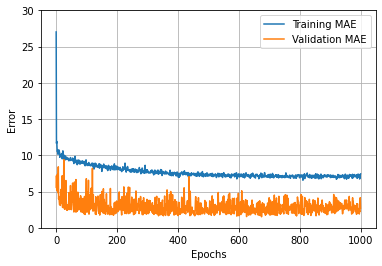

In [125]:
def plot_loss(history):
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.ylim([0, 30])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

### Analyzing predictions generated from X_test against actual values (y_test)

25/25 [==============================] - 0s 444us/step


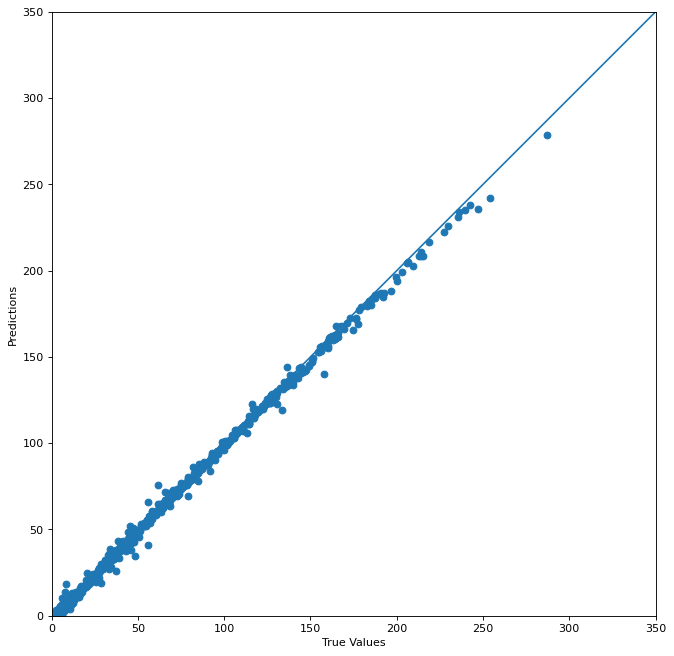

In [126]:
test_predictions = model.predict(X_test).flatten()

fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 350]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [127]:
# Create a dataframe to examine the details from actual values VS our predictions

checkdf = pd.DataFrame()
checkdf['actual'] = y_test
checkdf['prediction'] = test_predictions
checkdf['diff'] = checkdf['actual'] - checkdf['prediction']
checkdf.describe()

actual  prediction        diff
count  770.000000  770.000000  770.000000
mean    63.023117   61.198830    1.824296
std     56.913669   56.737942    2.529984
min     -0.300000   -5.644112  -14.414743
25%     14.400000   12.664654    0.652621
50%     46.300000   45.555855    1.703692
75%    100.575000   99.663551    2.887425
max    287.300000  278.753296   17.819366

In [128]:
checkdf.head(5)

actual  prediction      diff
63     101.8  100.269859  1.530141
1927    16.2   14.608646  1.591354
2026   108.9  107.707100  1.192900
331    110.9  108.507423  2.392577
2816     1.7   -1.544155  3.244155

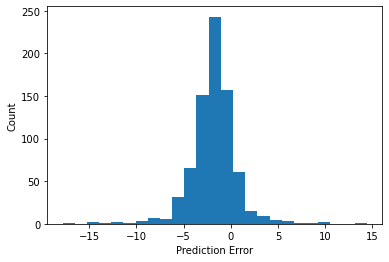

In [129]:
# Distribution of the errors margin. Pretty much standardized around 0 (normal curve)

error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

### Using the latest player stats (2021-2022 season) as our validation set and to predict next season's top performers

In [158]:
X_2021 = df_wr[df_wr['season'] == 2021]
y_2021 = X_2021['fantasy_points']
X_test2021 = X_2021.drop(columns=['player_id','position','name','fantasy_points'])

X_test2021 = StandardScaler().fit_transform(X_test2021)

val_predz = model.predict(X_test2021).flatten()
X_2021['predicted_points'] = val_predz
X_2021 = X_2021.sort_values(by=['predicted_points'],ascending=False)

7/7 [==============================] - 0s 665us/step


In [159]:
results = X_2021[['season','name','fantasy_points','predicted_points']]
results = results.reset_index(drop=True)
results

season              name  fantasy_points  predicted_points
0      2021       Cooper Kupp          294.50        300.894440
1      2021     Davante Adams          221.30        232.971222
2      2021  Justin Jefferson          222.40        231.449738
3      2021     Ja'Marr Chase          223.60        228.568909
4      2021     Tyshun Samuel          261.96        223.151306
..      ...               ...             ...               ...
210    2021      Alex Bachman           -0.30         -0.043461
211    2021    Isaiah Coulter            0.00         -0.063404
212    2021       David Moore            0.00         -0.192570
213    2021   Tyrie Cleveland            0.00         -0.208462
214    2021  Geronimo Allison            0.00         -0.238941

[215 rows x 4 columns]

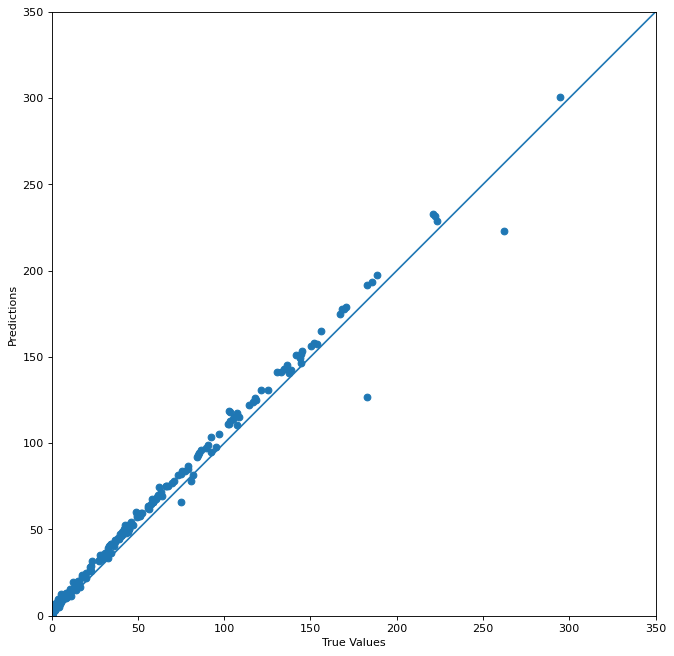

In [160]:
# Looks of our model against the 2021 data. Still very good prediction value overall

fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_2021, val_predz)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 350]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [133]:
# Create a dataframe to examine the details from actual values VS our predictions

df2021 = pd.DataFrame()

y_2021 = y_2021.reset_index(drop=True)

df2021['actual'] = y_2021
df2021['prediction'] = val_predz
df2021['diff'] = df2021['actual'] - df2021['prediction']
df2021.describe()

actual  prediction        diff
count  209.000000  209.000000  209.000000
mean    53.995885   60.087044   -6.091171
std     57.535220   58.167412    6.132632
min     -0.300000    0.714382  -17.325126
25%      6.800000   11.547771   -9.123969
50%     37.000000   44.674839   -7.010547
75%     81.000000   86.457664   -4.207279
max    294.500000  302.397125   54.184961

In [134]:
df2021.head(5)

actual  prediction      diff
0    44.8   51.810547 -7.010547
1    55.8   64.645782 -8.845782
2    89.7   98.412384 -8.712384
3    11.4   12.851738 -1.451738
4    79.1   88.186783 -9.086783

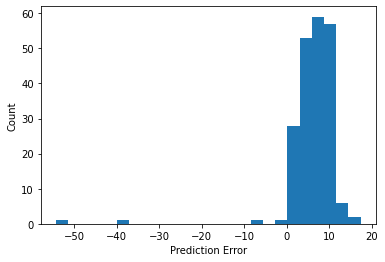

In [136]:
# A little higher error margin which was to be expected for future year values. Still more than acceptable results

error = val_predz - y_2021.values
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

### Let's compare my results against one of the most popular fantasy football resource available (what I usually use to make my picks every year!)

In [139]:
# Generating my official draft order (based on predictions)

draft = results[['name','predicted_points']]

draft.to_csv("C:/Users/phili/OneDrive/Desktop/draft.txt")

# Neural network vs classical regression

In [188]:
cols = list(X_2021.columns)
dropz = ['player_id','position','name','fantasy_points']

for i in dropz:
    cols.remove(i)

In [187]:
# Receiving yards and receiving TDs okay, highly positive valuation
# Target share, air yards shares should have highly positive valuation as well

for i,j in zip(cols, regr.coef_):
    print(i,j)

season -0.10437736215083411
completions 0.1415518563589429
attempts 0.29250705952446493
passing_yards 0.035244871385879444
passing_tds 0.4758143692872491
passing_air_yards 0.0775996559066682
passing_yards_after_catch -0.022877593742857437
passing_2pt_conversions -0.03385839752935906
carries -0.18338609670919703
rushing_yards 2.937415018333411
rushing_tds 1.4198846001230705
rushing_fumbles -0.05848425324058844
rushing_fumbles_lost -0.2505357354347657
rushing_first_downs 0.19775565725437683
rushing_epa -0.18543127308214233
rushing_2pt_conversions 0.09966474741972726
receptions -1.7819894504623166
targets 0.9383164336250617
receiving_yards 39.30314819601167
receiving_tds 18.776556789709613
receiving_fumbles -0.07672689706716299
receiving_fumbles_lost -0.968767500533111
receiving_air_yards -0.11616331023445754
receiving_yards_after_catch 0.25228876687747154
receiving_first_downs 0.1930779368145086
receiving_epa 0.12285380859110218
receiving_2pt_conversions 0.5476101564584157
pacr 4.4408920

In [178]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.04377362e-01  1.41551856e-01  2.92507060e-01  3.52448714e-02
  4.75814369e-01  7.75996559e-02 -2.28775937e-02 -3.38583975e-02
 -1.83386097e-01  2.93741502e+00  1.41988460e+00 -5.84842532e-02
 -2.50535735e-01  1.97755657e-01 -1.85431273e-01  9.96647474e-02
 -1.78198945e+00  9.38316434e-01  3.93031482e+01  1.87765568e+01
 -7.67268971e-02 -9.68767501e-01 -1.16163310e-01  2.52288767e-01
  1.93077937e-01  1.22853809e-01  5.47610156e-01  4.44089210e-16
  1.06581410e-14 -1.33226763e-14 -3.55271368e-15 -5.32907052e-15
  3.85365535e-01 -6.66245235e-01  7.31101107e-01  8.28859220e-02
 -7.81671760e-01 -2.48805529e+00 -4.78192779e-02  5.10978031e+00
 -6.33814992e+00 -8.60919037e-02 -1.12596575e-01  4.18641608e-01
  4.28026009e+00 -4.43914576e-02]
Index(['player_id', 'season', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds',
       'rush

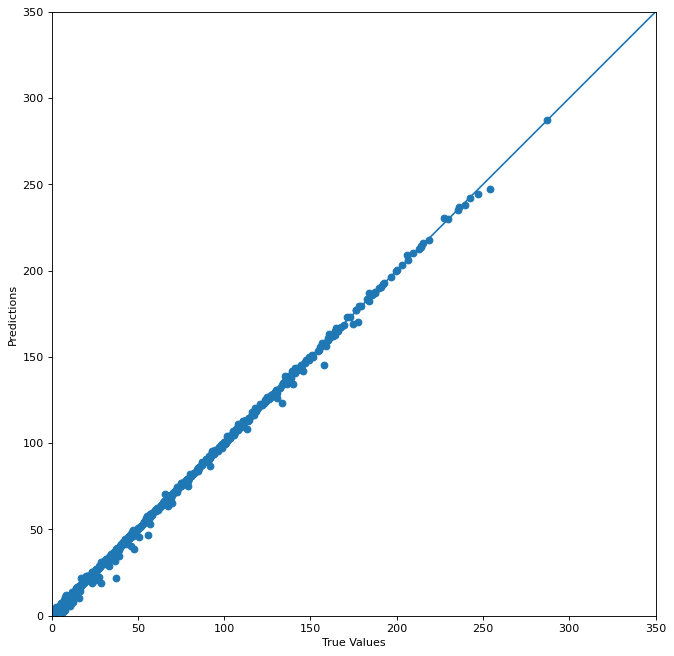

In [26]:
fig = plt.figure(figsize=(10,10), dpi = 80)

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 350]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [27]:
# 0 predictive capabilities

new = regr.predict(X_2021)

for i,j in zip(y_2021,new):
    print(i,j)

44.8 55.58372771500481
55.800000000000004 66.60610037511506
89.7 100.34730523703507
11.4 14.14255812782767
79.10000000000001 90.82632420521865
102.80000000000001 114.69027886554687
49.400000000000006 58.829811221215316
67.6 79.51371784057858
10.1 18.61485881464594
77.3 87.95916634778771
0.0 8.172966763429379
107.2 119.20694995975617
51.1 60.33209710721813
17.700000000000003 26.520290511051627
9.200000000000001 18.326296525674735
132.8 147.223231603339
37.199999999999996 47.129577238128995
12.9 21.88591826543434
151.8 163.65957590216877
92.2 98.34286576096676
29.4 38.23551142889852
105.2 117.79309019818098
182.6 151.62188225389252
3.8000000000000003 12.450742157116977
23.000000000000004 32.605532930425206
0.0 8.359819637197788
85.1 96.5796353627536
141.8 155.40134949889728
-0.30000000000000004 7.976654782036057
43.400000000000006 52.576498932968555
221.3 238.57749714619945
81.0 83.08057275250144
188.5 206.001940551642
49.0 58.07320361234759
134.5 148.55333407820825
3.8000000000000003 12

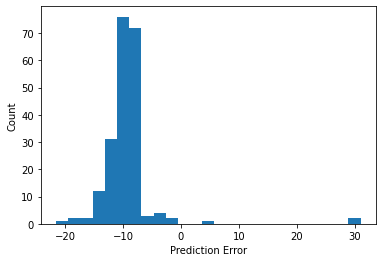

In [28]:
error = y_2021.values - new
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [33]:
valdf = pd.DataFrame()

predo = pd.Series(new)
y_2021 = y_2021.reset_index(drop=True)

valdf['actual'] = y_2021
valdf['prediction'] = predo

valdf['diff'] = valdf['actual'] - valdf['prediction']

valdf.describe()


actual  prediction        diff
count  208.000000  208.000000  208.000000
mean    53.180481   62.548475   -9.367994
std     56.450520   57.119439    4.714771
min     -0.300000    7.842358  -21.537659
25%      6.700000   15.517914  -10.789321
50%     36.950000   46.811697   -9.264313
75%     79.575000   89.238436   -8.461901
max    294.500000  316.037659   30.978118

In [189]:
valdf = pd.DataFrame()

predoz = pd.Series(val_predz)

valdf['actual'] = y_2021
valdf['prediction'] = predoz

valdf['diff'] = valdf['actual'] - valdf['prediction']

valdf.describe()

actual  prediction  diff
count  209.000000         0.0   0.0
mean    53.995885         NaN   NaN
std     57.535220         NaN   NaN
min     -0.300000         NaN   NaN
25%      6.800000         NaN   NaN
50%     37.000000         NaN   NaN
75%     81.000000         NaN   NaN
max    294.500000         NaN   NaN

Mean squared error (MSE) (tf.keras.losses.MeanSquaredError) and mean absolute error (MAE) (tf.keras.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

Similarly, evaluation metrics used for regression differ from classification.

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.

Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.

Neural network VS regression:
    - It's hard to understand exactly why the NN worked. Why it's producing quality outputs and why you should trust it
    - On the otherhand, regression is fairly simple to understand. In my case, it produced an equation with an
      R2 of 1.00 which is perfect. So, we were able to find a perfect solution to the problem at hand. Looking at the 
      coefficients though, to try and understand which values had the highest importance in the analysis we can
      conclude that it doesn't make too much sense. It's okay in this case but I would rather trust our NN with 
      predictions.



In [68]:
### To compare our neural network with standard regression models, let's use the following metrics :
### - Mean squared error - Mean absolute error

score = model.evaluate(X_test, y_test)
print("Mean square error from neural net", score[2])
print("Mean absolute error from neural net", score[1])

25/25 [==============================] - 0s 628us/step - loss: 3.9176 - mae: 3.9176 - mse: 35.1132
Mean square error from neural net 35.11318588256836
Mean absolute error from neural net 3.9176459312438965


In [76]:
mse_lr = mean_squared_error(y_test,y_pred)
mae_lr = mean_absolute_error(y_test,y_pred)
print("Mean square error from linear regression", mse_lr)
print("Mean absolute error from linear regression", mae_lr)

Mean square error from linear regression 2.7253765693705923
Mean absolute error from linear regression 0.9116465059005112


In [77]:
# Decision tree

tree = DecisionTreeRegressor()
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)
mse_dt = mean_squared_error(y_test,y_pred_tree)
mae_dt = mean_absolute_error(y_test,y_pred_tree)
print("Mean square error from linear regression", mse_dt)
print("Mean absolute error from linear regression", mae_dt)

Mean square error from linear regression 43.69149610389611
Mean absolute error from linear regression 3.5528311688311685
